In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats as spicystats
import sys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, roc_curve

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
import statsmodels.api as sm


from sklearn.preprocessing import StandardScaler

sys.path.insert(0, '../src')
sys.path.insert(0, '../data')


import chess

%load_ext autoreload
%autoreload 2


In [4]:
# Read in chess dataset and sample it.
chess_games = pd.read_csv("../data/games.csv")
chess_games.sample(10)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
13419,TtsbqLrX,False,1.503058e+12,1.503059e+12,38,resign,black,15+0,shaeila89,1384,zher0,1709,e4 c5 Nf3 Nc6 d4 cxd4 Nxd4 Nf6 Nc3 e5 Nf5 d5 e...,B33,Sicilian Defense: Lasker-Pelikan Variation,10
7762,ew4e0wrO,True,1.451440e+12,1.451440e+12,13,resign,black,15+0,xamio,913,tainamurilo,1058,e4 e5 Nf3 Nc6 d3 Bc5 Nc3 Nf6 b4 Bd4 Bg5 Bxc3+ Nd2,C44,King's Knight Opening: Normal Variation,4
9646,AxGtAluc,True,1.493854e+12,1.493854e+12,37,resign,white,10+0,pawnisle,1518,mashi,1408,e4 e5 Bc4 Nc6 Nf3 Bc5 O-O Nf6 d3 O-O h3 Ne8 Nc...,C50,Giuoco Piano,6
4140,9nhiwIrc,True,1.502730e+12,1.502730e+12,32,resign,black,10+10,yak42,1508,lcover,1440,e4 c5 d4 cxd4 Qxd4 Nc6 Qd1 e5 Nf3 Nf6 Bg5 h6 B...,B21,Sicilian Defense: Smith-Morra Gambit #2,3
9171,gf71eoJM,True,1.416430e+12,1.416430e+12,22,resign,white,10+35,frantaiq,1558,acj4-chess,1500,e4 Nc6 Bc4 Ne5 Bb3 d5 d4 b5 dxe5 a5 Bxd5 c5 Bx...,B00,Nimzowitsch Defense,2
1973,9MpjI8xF,True,1.487590e+12,1.487590e+12,69,mate,white,3+12,sudorous,1733,sveenemand,1199,d4 d6 c4 e6 e4 Bd7 Nf3 Be7 Nc3 Nc6 g3 Nf6 Bg2 ...,A41,Old Indian Defense,3
16739,JGbVPeDG,False,1.476051e+12,1.476052e+12,69,mate,white,10+5,chesslearningpro,1653,enricolord,1176,d4 d5 e3 Nf6 c4 Bg4 Be2 e6 Bxg4 Bb4+ Bd2 Bxd2+...,D00,Queen's Pawn Game #3,4
13781,ccx5sbdg,True,1.503152e+12,1.503154e+12,156,draw,draw,15+5,gjdgjdfj,1819,sazed,2071,e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6 d3 b5 Bb3 Be7 O-O...,C94,Ruy Lopez: Morphy Defense | Breyer Defense | ...,19
18671,4WF9eDyU,False,1.474079e+12,1.474080e+12,69,outoftime,white,8+2,aboud,1828,maxmok09,1500,c4 c5 Nf3 d6 Nc3 e6 g3 Nf6 d3 h6 Bg2 d5 Bf4 Nb...,A30,English Opening: Symmetrical Variation,2
17600,vxdojV9B,False,1.469044e+12,1.469045e+12,73,resign,white,15+0,ninocrea,1528,reubpear,1539,e4 e5 Nf3 Nf6 d3 Bb4+ c3 Bc5 Bg5 Nc6 b4 Be7 Bx...,C42,Petrov's Defense,4


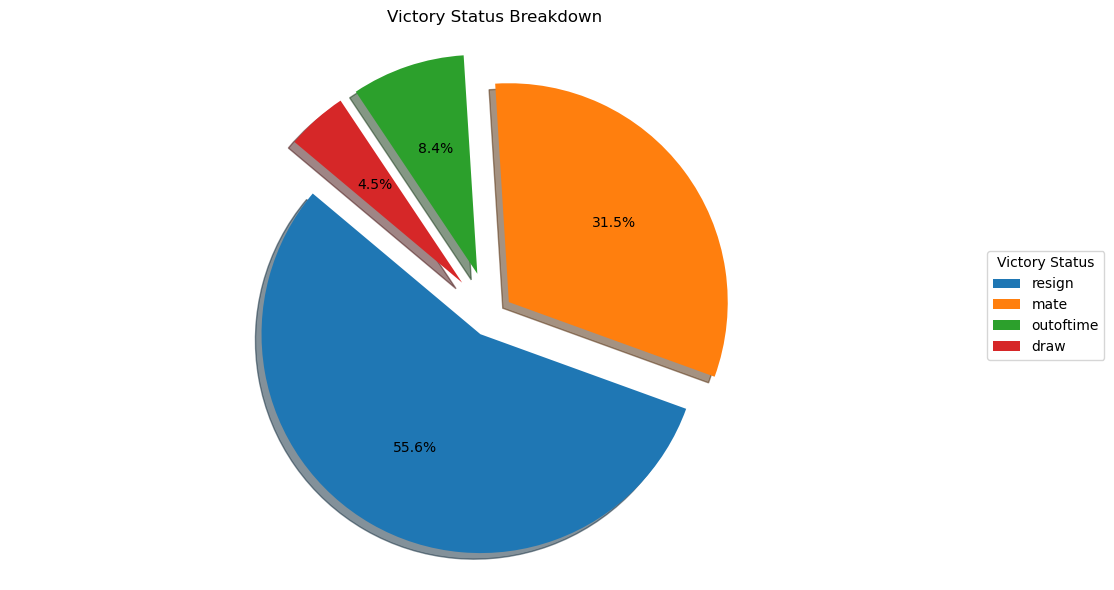

In [12]:
# Grab and count the chess victory status, broken down by category. 
def chess_victories(chess_df):
     victory_status = chess_df["victory_status"].value_counts()

     fig, ax = plt.subplots(figsize = (10,6))

     sizes = victory_status.values
     labels = victory_status.index.tolist()
     explode = (0.1, 0.1, 0.2, 0.2)
     c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
     plt.pie(sizes, explode=explode, colors=c, 
        autopct='%1.1f%%', shadow=True, startangle=140)
     ax.legend( labels, title="Victory Status",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
     ax.set_title("Victory Status Breakdown")
     plt.tight_layout()
     plt.axis('equal')
     plt.show()
     return victory_status
victories_breakdown = chess_victories(chess_games)


In [47]:
# Look at potential spearman and pearson correlations regarding player rating differential and victory status.
def chess_correlations(chess_df):
    remove_draws = chess_df[chess_df['victory_status'].str.contains('draw') == False]
    chess_df['Rating Differential White'] = (remove_draws['white_rating'] - remove_draws['black_rating'])
    white_greater_100 = chess_df[chess_df['Rating Differential White'] > 100]
    chess_df['Rating Differential Black'] = (remove_draws['black_rating'] - remove_draws['white_rating'])
    black_greater_100 = chess_df[chess_df['Rating Differential Black'] > 100]
    black_and_white = [white_greater_100, black_greater_100]
   
    combined_black_and_white = pd.concat(black_and_white)
    drop_rating_differential = combined_black_and_white.drop(columns=['Rating Differential'])
    correlation_pearson = drop_rating_differential['Cocoa Percentage as Float'].corr(choco_df['Rating'], method ='pearson')
    # correlation_spearman = choco_df['Cocoa Percentage as Float'].corr(choco_df['Rating'], method ='spearman')
    # correlation_dict = {"Cocoa Percentage & Rating Correlation: Spearman":correlation_pearson, "Cocoa Percentage & Rating Correlation: Pearson":correlation_spearman}
    return drop_rating_differential

draws_gone = chess_correlations(chess_games)
draws_gone

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,Rating Differential White,Rating Differential Black
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,309.0,-309.0
9,afoMwnLg,True,1.503440e+12,1.503440e+12,119,mate,white,10+0,daniel_likes_chess,1381,mirco25,1209,e4 d5 exd5 Qxd5 Nc3 Qe5+ Be2 Na6 d4 Qf5 Bxa6 b...,B01,Scandinavian Defense: Mieses-Kotroc Variation,4,172.0,-172.0
10,HgKLWPsz,False,1.503350e+12,1.503350e+12,39,mate,white,20+60,daniel_likes_chess,1381,anaissac,1272,e3 e6 d4 d6 Bd3 c6 Nf3 Be7 Nc3 Nf6 Bd2 Bd7 Qe2...,A00,Van't Kruijs Opening,1,109.0,-109.0
19,x31mXlvc,False,1.503760e+12,1.503760e+12,25,resign,white,11+0,g-ios,1500,shivangithegenius,1094,d4 d5 h3 Nc6 Nf3 Nf6 Bg5 h6 Bxf6 exf6 e3 Bb4+ ...,D00,Queen's Pawn Game,2,406.0,-406.0
22,5cgBygpI,False,1.502950e+12,1.502950e+12,17,resign,white,15+5,storm28rus,1500,shivangithegenius,1094,e4 c5 Bc4 Nf6 Nc3 d6 Nf3 g6 Ng5 e6 d3 Bg7 O-O ...,B20,Sicilian Defense: Bowdler Attack,3,406.0,-406.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20036,cDSybWIj,True,1.501013e+12,1.501014e+12,43,mate,white,10+0,jamboger,1247,mhm98,1436,c4 e5 Nc3 Bc5 e3 Nc6 a3 Nf6 b4 Bd6 Nf3 a6 c5 B...,A21,English Opening: King's English Variation | R...,3,-189.0,189.0
20038,xAQi2hl2,True,1.501011e+12,1.501012e+12,36,resign,black,15+15,jamboger,1247,jcv29,1359,c4 e5 Nc3 Bb4 Nd5 a5 Nf3 Nc6 a3 Bc5 d3 Nf6 Bd2...,A21,English Opening: King's English Variation | K...,4,-112.0,112.0
20040,yM2DgyaO,True,1.500296e+12,1.500297e+12,87,resign,black,10+10,jamboger,1261,lyca,1461,c4 Nf6 d4 e6 Nc3 Bb4 Bd2 c5 Be3 b6 Nf3 Bb7 g3 ...,E20,Nimzo-Indian Defense,6,-200.0,200.0
20041,B4IEyQyb,True,1.500157e+12,1.500158e+12,58,mate,black,10+10,jamboger,1263,kevineclmans,1770,d4 d5 Bf4 Bf5 e3 Nf6 c3 e6 Nf3 Nh5 Bg5 f6 Bh4 ...,D00,Queen's Pawn Game: Mason Attack,3,-507.0,507.0


In [ ]:
# Null Hypothesis: The rating differential between black and white has no significant impact on which player wins the game.
# Alternate Hypothesis: The rating differential between black and white has a significant impact on which player wins the game.